In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
import pickle
import bz2
from glob import glob

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys, Descriptors, PandasTools, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.DataStructs import ExplicitBitVect

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score,
    roc_auc_score, cohen_kappa_score
)
from sklearn.model_selection import (
    train_test_split, RepeatedStratifiedKFold,
    ShuffleSplit, StratifiedShuffleSplit
)

from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check

# Optional: untuk autoreload jika di Jupyter
# %reload_ext autoreload
# %autoreload 2

# Suppress warnings
warnings.filterwarnings("ignore")
warnings.warn = lambda *args, **kwargs: None

In [2]:
import pandas as pd

# Fungsi untuk ubah string ke list of int
def string_to_list(bit_string):
    if isinstance(bit_string, str):
        return list(map(int, bit_string.strip('[]').split(', ')))
    return bit_string

# Load test set dari Excel
test_file = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
test_df = pd.read_excel(test_file)

# Konversi kolom deskriptor jika masih berupa string
for col in ['Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors']:
    if col in test_df.columns:
        if isinstance(test_df[col].iloc[0], str):
            test_df[col] = test_df[col].apply(string_to_list)

# Tampilkan hasil
print("Test DataFrame:")
print(test_df.head())


Test DataFrame:
                                              SMILES  Outcome  \
0  CCN=C1C=CC(=C(c2ccc(NCC)cc2)c2ccc(NCC)c(C)c2)C=C1        0   
1                              CCCCCCCCOC(=O)CCCCCCC        0   
2                                      CCCC[Sn](=O)O        0   
3                 CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O        0   
4                                       C=COC1CCCCC1        0   

                                  Morgan_Descriptors  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                   MACCS_Descriptors  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [3]:
# Melihat nama-nama kolom yang ada di DataFrame
print("Daftar kolom dalam test_df:")
print(test_df.columns.tolist())

Daftar kolom dalam test_df:
['SMILES', 'Outcome', 'Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors', 'Molecular Weight', 'logP', 'LabuteASA', 'TPSA', 'AMW', 'NumRotatableBonds', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'NumAromaticCarbocycles', 'NumSaturatedCarbocycles', 'NumAliphaticCarbocycles', 'FractionCSP3', 'Chi0v', 'Chi1v', 'Chi2v', 'Chi3v', 'Chi4v', 'Chi1n', 'Chi2n', 'Chi3n', 'Chi4n', 'HallKierAlpha', 'Heavy Atom Count', 'Ring Count', 'Num H Donors', 'Num H Acceptors', 'ALogP', 'ALogp2', 'AMR', 'MLogP', 'nAtomP', 'naAromAtom', 'bpol', 'nB', 'ECCEN', 'fragC', 'nHBAcc', 'nHBDon', 'nAtomLAC', 'nAtomLC', 'PetitjeanNumber', 'nRotB', 'LipinskiFailures', 'TopoPSA', 'VAdjMat', 'XLogP', 'Fsp3']


In [4]:
# Cek jumlah NaN sebelum dihapus
nan_before = test_df.isnull().sum().sum()

# Hapus baris yang mengandung NaN
test_df = test_df.dropna()

# Tampilkan informasi jumlah NaN
if nan_before > 0:
    print(f"Total nilai NaN yang dihapus dari test_df: {nan_before}")
else:
    print("Tidak ada nilai NaN yang ditemukan dalam test_df.")

Tidak ada nilai NaN yang ditemukan dalam test_df.


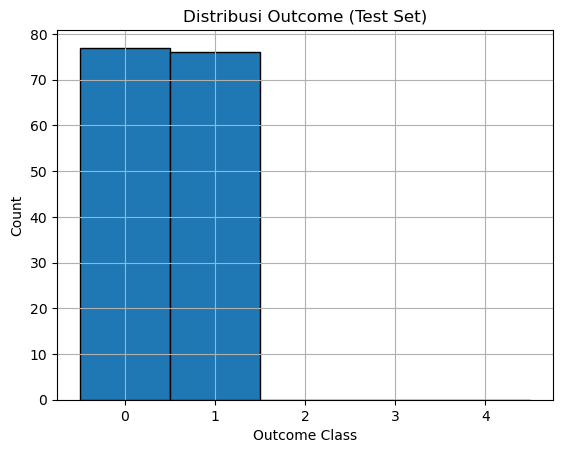

Classes                          : [0 1]
Number of cpds in each class     : [77 76]
Total number of cpds             : 153
Label mapping (kelas → angka): {0: 0, 1: 1}


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Buat salinan kolom Outcome
S = test_df['Outcome'].copy()

# Plot distribusi kelas
fig, ax = plt.subplots()
ax = S.hist(bins=np.arange(-0.5, 5), edgecolor='black')
ax.set_xticks(range(0, 5))
ax.set_xlabel("Outcome Class")
ax.set_ylabel("Count")
ax.set_title("Distribusi Outcome (Test Set)")
plt.show()

# Encoding label
le = LabelEncoder()
outcomes = np.unique(test_df['Outcome'])
le.fit(outcomes)
y = le.transform(test_df['Outcome'])

# Info distribusi
print("Classes                          :", outcomes)
print("Number of cpds in each class     :", np.bincount(y))
print("Total number of cpds             :", len(y))

# Ganti label Outcome menjadi angka (mapping)
S = test_df['Outcome']
info = {}
for i, cls in enumerate(S.unique()):
    info[cls] = i
    S = S.replace(cls, i)

# Optional: simpan mapping info kalau mau pakai nanti
print("Label mapping (kelas → angka):", info)

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Ambil label Outcome dari test_df
S = test_df['Outcome'].copy()

# Encode label ke angka
info = {}
for i, cls in enumerate(S.unique()):
    info[cls] = i
    S = S.replace(cls, i)

# Konversi label ke numpy array bertipe int32
y_test = np.int32(S)

# Konversi MACCS, Morgan, dan APF Descriptors ke array numpy
def convert_to_array(desc_list):
    return np.array([eval(desc) if isinstance(desc, str) else desc for desc in desc_list])

x_test_macckeys = convert_to_array(test_df['MACCS_Descriptors'])
x_test_morgan = convert_to_array(test_df['Morgan_Descriptors'])
x_test_apf = convert_to_array(test_df['APF_Descriptors'])  # <-- tambahan APF

# Cek isi
print("Label classes (encoded)       :", info)
print("Jumlah senyawa per kelas      :", np.bincount(y_test))
print("Total jumlah senyawa (test)   :", len(y_test))
print("x_test_macckeys shape         :", x_test_macckeys.shape)
print("x_test_morgan shape           :", x_test_morgan.shape)
print("x_test_apf shape              :", x_test_apf.shape)  # <-- cek APF


Label classes (encoded)       : {0: 0, 1: 1}
Jumlah senyawa per kelas      : [77 76]
Total jumlah senyawa (test)   : 153
x_test_macckeys shape         : (153, 167)
x_test_morgan shape           : (153, 1024)
x_test_apf shape              : (153, 1024)


In [7]:
x_rdkitcdk = test_df.drop(columns=['SMILES',
    'Outcome',
    'Morgan_Descriptors',
    'MACCS_Descriptors',
    'APF_Descriptors'])
x_rdkitcdk

,Molecular Weight,logP,LabuteASA,TPSA,AMW,NumRotatableBonds,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,...,nHBDon,nAtomLAC,nAtomLC,PetitjeanNumber,nRotB,LipinskiFailures,TopoPSA,VAdjMat,XLogP,Fsp3
0,385.555,6.24742,174.518094,36.42,385.555,7,2,0,1,0,...,2,2,3,0.500000,7,1,36.42,5.954196,5.563,0.269231
1,256.430,5.25060,113.488450,26.30,256.430,13,0,0,0,0,...,0,8,17,0.500000,14,2,26.30,5.087463,6.965,0.937500
2,208.833,0.69750,51.207886,37.30,208.833,3,0,0,0,0,...,1,4,6,0.400000,3,0,37.30,3.584963,1.130,1.000000
3,290.447,3.95910,128.240640,37.30,290.447,0,0,4,4,0,...,1,0,0,0.500000,0,0,37.30,5.584963,4.498,0.947368
4,126.199,2.47920,56.711957,9.23,126.199,2,0,1,1,0,...,0,2,3,0.500000,2,0,9.23,4.169925,2.652,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,80.514,0.21750,30.201693,20.23,80.514,1,0,0,0,0,...,1,2,4,0.333333,1,0,20.23,2.584963,0.266,1.000000
149,359.573,5.72830,132.731498,44.76,359.573,7,1,0,0,0,...,0,2,8,0.500000,7,0,54.57,5.321928,4.866,0.333333
150,209.245,2.19200,89.194588,47.56,209.245,3,1,0,0,0,...,1,3,4,0.500000,5,0,47.56,4.906891,1.977,0.363636
151,246.337,4.14460,95.082999,9.23,246.337,5,1,0,0,0,...,0,2,6,0.500000,5,0,76.43,4.807355,4.702,0.400000


In [8]:
print(x_rdkitcdk)

     Molecular Weight     logP   LabuteASA    TPSA      AMW  \
0             385.555  6.24742  174.518094   36.42  385.555   
1             256.430  5.25060  113.488450   26.30  256.430   
2             208.833  0.69750   51.207886   37.30  208.833   
3             290.447  3.95910  128.240640   37.30  290.447   
4             126.199  2.47920   56.711957    9.23  126.199   
..                ...      ...         ...     ...      ...   
148            80.514  0.21750   30.201693   20.23   80.514   
149           359.573  5.72830  132.731498   44.76  359.573   
150           209.245  2.19200   89.194588   47.56  209.245   
151           246.337  4.14460   95.082999    9.23  246.337   
152           198.134  1.51702   77.896530  106.51  198.134   

     NumRotatableBonds  NumAromaticRings  NumSaturatedRings  \
0                    7                 2                  0   
1                   13                 0                  0   
2                    3                 0              

In [9]:
x_rdkitcdk  = x_rdkitcdk.apply(lambda row: row.values, axis=1).tolist()

# Add the new column 'rdkit_cdk' to test_df
test_df['rdkit_cdk'] = x_rdkitcdk 

# Display the updated DataFrame
print(test_df)

                                                SMILES  Outcome  \
0    CCN=C1C=CC(=C(c2ccc(NCC)cc2)c2ccc(NCC)c(C)c2)C=C1        0   
1                                CCCCCCCCOC(=O)CCCCCCC        0   
2                                        CCCC[Sn](=O)O        0   
3                   CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O        0   
4                                         C=COC1CCCCC1        0   
..                                                 ...      ...   
148                                              OCCCl        1   
149                CCOP(=O)(OCC)OC(=CCl)c1ccc(Cl)cc1Cl        1   
150                             CNC(=O)Oc1ccccc1OC(C)C        1   
151                              CCOP(=S)(CC)Sc1ccccc1        1   
152             Cc1c(O)cc([N+](=O)[O-])cc1[N+](=O)[O-]        1   

                                    Morgan_Descriptors  \
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...   
2    [0, 0, 0, 0, 0, 

In [10]:
y_test = np.int32(S)
x_test_morgan = np.array(list(test_df['Morgan_Descriptors']))
x_test_macckeys = np.array(list(test_df['MACCS_Descriptors']))
x_test_rdkit_cdk = np.array(list(test_df['rdkit_cdk']))
x_test_apf = np.array(list(test_df['APF_Descriptors']))  # <-- tambahan APF


In [11]:
y_test= np.int32((S))
x_test_rdkit_cdk

array([[3.85555000e+02, 6.24742000e+00, 1.74518094e+02, ...,
        5.95419631e+00, 5.56300000e+00, 2.69230769e-01],
       [2.56430000e+02, 5.25060000e+00, 1.13488450e+02, ...,
        5.08746284e+00, 6.96500000e+00, 9.37500000e-01],
       [2.08833000e+02, 6.97500000e-01, 5.12078856e+01, ...,
        3.58496250e+00, 1.13000000e+00, 1.00000000e+00],
       ...,
       [2.09245000e+02, 2.19200000e+00, 8.91945884e+01, ...,
        4.90689060e+00, 1.97700000e+00, 3.63636364e-01],
       [2.46337000e+02, 4.14460000e+00, 9.50829990e+01, ...,
        4.80735492e+00, 4.70200000e+00, 4.00000000e-01],
       [1.98134000e+02, 1.51702000e+00, 7.78965304e+01, ...,
        4.80735492e+00, 1.62600000e+00, 1.42857143e-01]])

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report


In [13]:
y_true = test_df['Outcome'].astype(int)  # Ensure it's of integer type, suitable for metrics calculation


In [14]:
test_df

,SMILES,Outcome,Morgan_Descriptors,MACCS_Descriptors,APF_Descriptors,Molecular Weight,logP,LabuteASA,TPSA,AMW,...,nAtomLAC,nAtomLC,PetitjeanNumber,nRotB,LipinskiFailures,TopoPSA,VAdjMat,XLogP,Fsp3,rdkit_cdk
0,CCN=C1C=CC(=C(c2ccc(NCC)cc2)c2ccc(NCC)c(C)c2)C=C1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",385.555,6.24742,174.518094,36.42,385.555,...,2,3,0.500000,7,1,36.42,5.954196,5.563,0.269231,"[385.5550000000001, 6.247420000000005, 174.518..."
1,CCCCCCCCOC(=O)CCCCCCC,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",256.430,5.25060,113.488450,26.30,256.430,...,8,17,0.500000,14,2,26.30,5.087463,6.965,0.937500,"[256.4299999999999, 5.250600000000006, 113.488..."
2,CCCC[Sn](=O)O,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",208.833,0.69750,51.207886,37.30,208.833,...,4,6,0.400000,3,0,37.30,3.584963,1.130,1.000000,"[208.833, 0.6975, 51.20788564281655, 37.3, 208..."
3,CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",290.447,3.95910,128.240640,37.30,290.447,...,0,0,0.500000,0,0,37.30,5.584963,4.498,0.947368,"[290.4469999999999, 3.959100000000003, 128.240..."
4,C=COC1CCCCC1,0,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",126.199,2.47920,56.711957,9.23,126.199,...,2,3,0.500000,2,0,9.23,4.169925,2.652,0.750000,"[126.199, 2.479200000000001, 56.71195687239921..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,OCCCl,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",80.514,0.21750,30.201693,20.23,80.514,...,2,4,0.333333,1,0,20.23,2.584963,0.266,1.000000,"[80.51400000000001, 0.2175, 30.20169312130384,..."
149,CCOP(=O)(OCC)OC(=CCl)c1ccc(Cl)cc1Cl,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",359.573,5.72830,132.731498,44.76,359.573,...,2,8,0.500000,7,0,54.57,5.321928,4.866,0.333333,"[359.5730000000001, 5.728300000000004, 132.731..."
150,CNC(=O)Oc1ccccc1OC(C)C,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",209.245,2.19200,89.194588,47.56,209.245,...,3,4,0.500000,5,0,47.56,4.906891,1.977,0.363636,"[209.245, 2.192, 89.19458843414556, 47.56, 209..."
151,CCOP(=S)(CC)Sc1ccccc1,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",246.337,4.14460,95.082999,9.23,246.337,...,2,6,0.500000,5,0,76.43,4.807355,4.702,0.400000,"[246.337, 4.144600000000003, 95.08299904203255..."


In [15]:
def convert_list_str_to_float(lst):
    return [float(x) for x in lst if x != '' and x is not None]

test_df['rdkit_cdk'] = test_df['rdkit_cdk'].apply(convert_list_str_to_float)

X_rdkitcdk = np.array(test_df['rdkit_cdk'].tolist(), dtype=float)

Semua model berhasil dimuat.

--- SVM_Morgan ---
Accuracy: 0.833, AUC: 0.910, F1: 0.853
Sensitivity: 0.870, Specificity: 0.786, CCR: 0.828
PPV: 0.838, NPV: 0.827



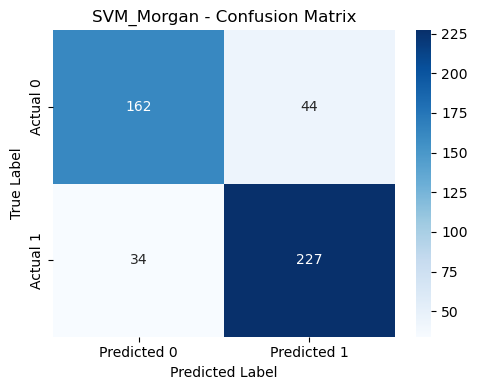

--- SVM_MACCS ---
Accuracy: 0.846, AUC: 0.925, F1: 0.866
Sensitivity: 0.889, Specificity: 0.791, CCR: 0.840
PPV: 0.844, NPV: 0.849



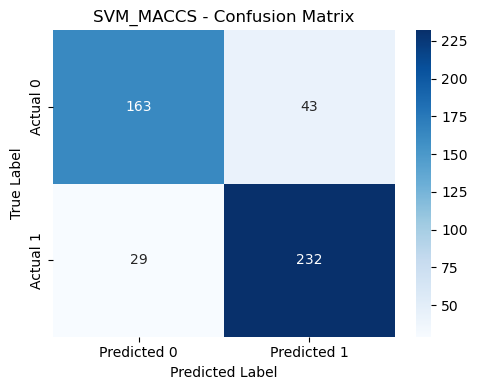

--- SVM_APF ---
Accuracy: 0.822, AUC: 0.886, F1: 0.847
Sensitivity: 0.881, Specificity: 0.748, CCR: 0.814
PPV: 0.816, NPV: 0.832



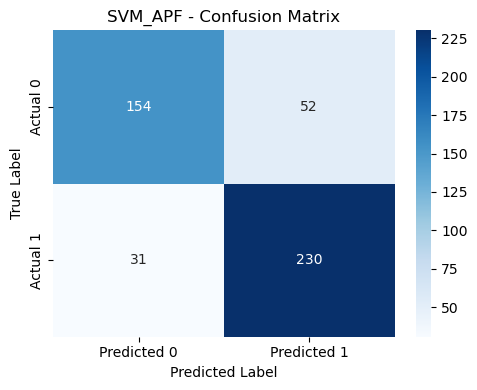

--- RF_Morgan ---
Accuracy: 0.842, AUC: 0.913, F1: 0.862
Sensitivity: 0.889, Specificity: 0.782, CCR: 0.835
PPV: 0.838, NPV: 0.847



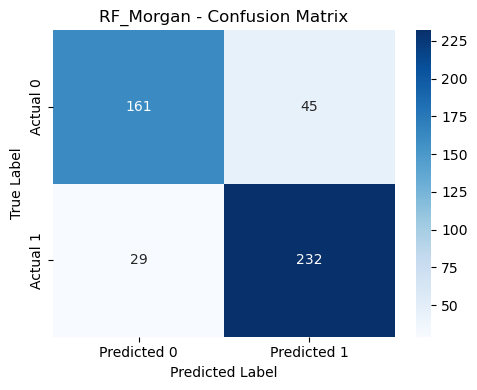

--- RF_MACCS ---
Accuracy: 0.861, AUC: 0.929, F1: 0.877
Sensitivity: 0.885, Specificity: 0.830, CCR: 0.858
PPV: 0.868, NPV: 0.851



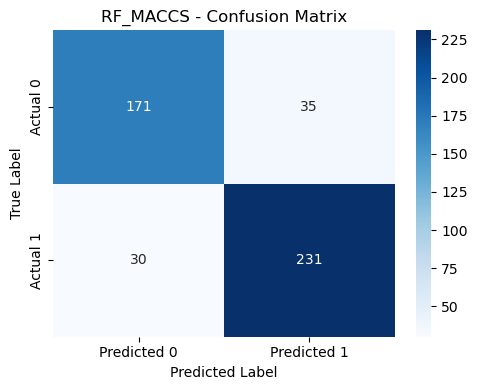

--- RF_APF ---
Accuracy: 0.835, AUC: 0.910, F1: 0.859
Sensitivity: 0.900, Specificity: 0.752, CCR: 0.826
PPV: 0.822, NPV: 0.856



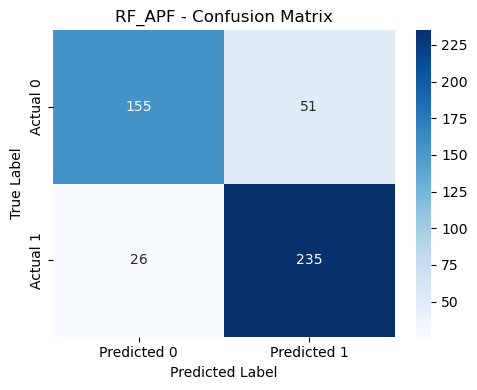

--- XGB_Morgan ---
Accuracy: 0.833, AUC: 0.897, F1: 0.851
Sensitivity: 0.854, Specificity: 0.806, CCR: 0.830
PPV: 0.848, NPV: 0.814



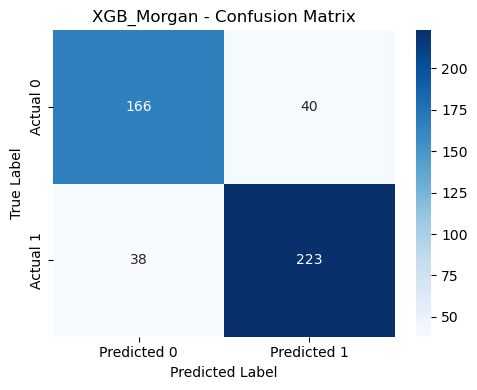

--- XGB_MACCS ---
Accuracy: 0.850, AUC: 0.923, F1: 0.867
Sensitivity: 0.877, Specificity: 0.816, CCR: 0.846
PPV: 0.858, NPV: 0.840



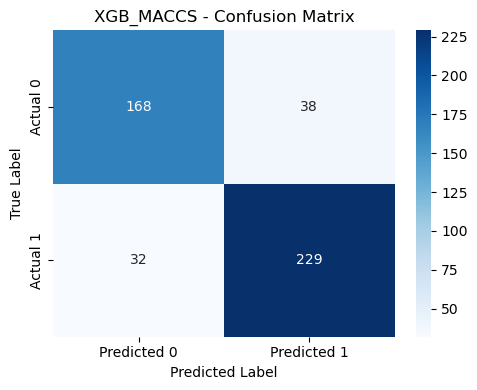

--- XGB_APF ---
Accuracy: 0.824, AUC: 0.900, F1: 0.846
Sensitivity: 0.866, Specificity: 0.772, CCR: 0.819
PPV: 0.828, NPV: 0.820



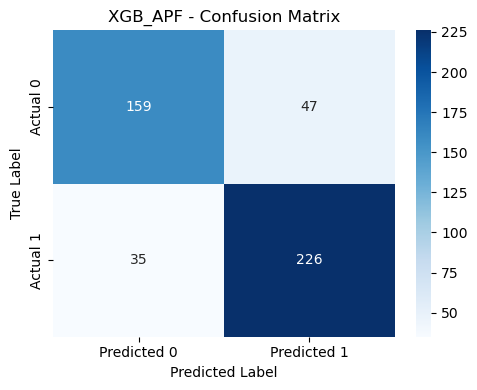

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score
import joblib
import pandas as pd
import os

# ==========================
# Load test set
# ==========================
test_file = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Dataset\Resp_Test_set_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
test_df = pd.read_excel(test_file)

# Jika kolom fingerprint masih string, konversi ke list
def string_to_list(bit_string):
    if isinstance(bit_string, str):
        return list(map(int, bit_string.strip('[]').split(', ')))
    return bit_string

for col in ['Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors']:
    if col in test_df.columns:
        if isinstance(test_df[col].iloc[0], str):
            test_df[col] = test_df[col].apply(string_to_list)

# Label
y_true = test_df['Outcome'].astype(int)

# ==========================
# Load semua model
# ==========================
models_info = {
    'SVM': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_SVM_morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_SVM_MACCS.pkl",
        'APF': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_SVM_APF.pkl"
    },
    'RF': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_rf_morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_rf_macckeys.pkl",
        'APF': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_rf_apf.pkl"
    },
    'XGB': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_xgb_morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_xgb_maccs.pkl",
        'APF': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Model\Resp_final_xgb_apf.pkl"
    }
}

# Load model ke dictionary
loaded_models = {}
for algo, fingerprints in models_info.items():
    loaded_models[algo] = {}
    for fp_name, path in fingerprints.items():
        loaded_models[algo][fp_name] = joblib.load(path)

print("Semua model berhasil dimuat.\n")

# ==========================
# Fungsi evaluasi model
# ==========================
def evaluate_model(model, X, y_true, model_name):
    probs = model.predict_proba(np.array(X.tolist()))[:, 1]
    preds = (probs > 0.5).astype(int)

    conf_matrix = confusion_matrix(y_true, preds)
    accuracy = accuracy_score(y_true, preds)
    auc_score = roc_auc_score(y_true, probs)
    f1 = f1_score(y_true, preds)
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ccr = (sensitivity + specificity) / 2
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}, F1: {f1:.3f}")
    print(f"Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}, CCR: {ccr:.3f}")
    print(f"PPV: {ppv:.3f}, NPV: {npv:.3f}\n")

    # Confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    return preds, probs

# ==========================
# Evaluasi semua model dan simpan hasil
# ==========================
results_df = test_df.copy()  # Buat salinan untuk simpan prediksi/probabilitas

for algo, fps in loaded_models.items():
    for fp_name, model in fps.items():
        model_label = f"{algo}_{fp_name}"
        preds, probs = evaluate_model(model, test_df[f"{fp_name}_Descriptors"], y_true, model_label)
        results_df[f"{model_label}_Pred"] = preds
        results_df[f"{model_label}_Prob"] = probs

# # ==========================
# # Simpan ke Excel
# # ==========================
# save_path = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Respiratory Irritation New\Evaluation\Resp_Test_set_Model_Evaluation.xlsx"
# os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Pastikan folder ada
# results_df.to_excel(save_path, index=False)
# print(f"Hasil prediksi semua model telah disimpan ke: {save_path}")


# EVALUASI RDKIT-CDK DESCRIPTORS

In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import joblib
import os

# Load semua model Hepatotoxicity
# ==========================
models_info = {
    'SVM': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS.pkl",
        'APF':   r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_svm_rdkitcdk.pkl"
    },
    'RF': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_macckeys.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_rdkitcdk.pkl"
    },
    'XGB': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_maccs.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_rdkitcdk.pkl"
    }
}

loaded_models = {}
for algo, fps in models_info.items():
    loaded_models[algo] = {}
    for fp_name, path in fps.items():
        loaded_models[algo][fp_name] = joblib.load(path)

print("Semua model Dermal Toxicity berhasil dimuat.\n")

Semua model Dermal Toxicity berhasil dimuat.



In [23]:
test_set = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import joblib
import itertools
import os
import ast  # untuk konversi string ke list

# ==========================
# Load test sets
# ==========================
test_files = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
test_df = pd.read_excel(test_files)

# ==========================
# Drop kolom yang tidak digunakan & buat X_rdkitcdk
# ==========================
drop_cols = ['SMILES', 'Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors', 'Outcome']
x_rdkitcdk_test = test_df.drop(columns=drop_cols)
y_true = test_df['Outcome'].astype(int).values

# Load semua model Hepatotoxicity
# ==========================
models_info = {
    'SVM': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS.pkl",
        'APF':   r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_svm_rdkitcdk.pkl"
    },
    'RF': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_macckeys.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_rdkitcdk.pkl"
    },
    'XGB': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_maccs.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_rdkitcdk.pkl"
    }
}


loaded_models = {}
for algo, fps in models_info.items():
    loaded_models[algo] = {}
    for fp_name, path in fps.items():
        loaded_models[algo][fp_name] = joblib.load(path)

print("Semua model Hepatotoxicity berhasil dimuat.\n")

# ==========================
# Fungsi bootstrap metrics
# ==========================
def bootstrap_metrics(probs, y_true, n_bootstrap=1000, ci=0.95, random_state=42):
    rng = np.random.RandomState(random_state)
    preds = (probs > 0.5).astype(int)
    
    acc_list, sen_list, spe_list, auc_list = [], [], [], []
    tn_list, fp_list, fn_list, tp_list = [], [], [], []
    n_samples = len(y_true)

    for _ in range(n_bootstrap):
        idx = rng.choice(np.arange(n_samples), size=n_samples, replace=True)
        y_sample = y_true[idx]
        p_sample = probs[idx]
        pred_sample = preds[idx]

        tn, fp, fn, tp = confusion_matrix(y_sample, pred_sample).ravel()
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        tp_list.append(tp)

        acc_list.append(accuracy_score(y_sample, pred_sample))
        sen_list.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        spe_list.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        try:
            auc_list.append(roc_auc_score(y_sample, p_sample))
        except:
            auc_list.append(np.nan)

    lower = (1 - ci)/2
    upper = 1 - lower

    def format_metric(values):
        mean_val = np.nanmean(values)
        low = np.nanpercentile(values, 100*lower)
        high = np.nanpercentile(values, 100*upper)
        half_width = (high - low) / 2
        return f"{mean_val:.2f} ± {half_width:.2f}"

    metrics = {
        'Accuracy': format_metric(acc_list),
        'Sensitivity': format_metric(sen_list),
        'Specificity': format_metric(spe_list),
        'AUC': format_metric(auc_list),
        'TN': int(np.mean(tn_list)),
        'FP': int(np.mean(fp_list)),
        'FN': int(np.mean(fn_list)),
        'TP': int(np.mean(tp_list))
    }
    return metrics

# ==========================
# Buat semua kombinasi model (81 kombinasi)
# ==========================
fingerprints = ['Morgan', 'MACCS', 'APF', 'RDKitCDK']
algorithms = ['SVM', 'RF', 'XGB']
all_combinations = list(itertools.product(algorithms, repeat=len(fingerprints)))
print(f"Jumlah kombinasi model: {len(all_combinations)}")  # 81

# ==========================
# Fungsi untuk mengubah string list menjadi array numerik
# ==========================
def convert_to_array(series):
    return np.array(series.apply(ast.literal_eval).tolist())

# ==========================
# Hitung probabilitas consensus & metrics untuk tiap kombinasi
# ==========================
results_list = []

for combo in all_combinations:
    probs_list = []
    for fp, algo in zip(fingerprints, combo):
        model = loaded_models[algo][fp]
        if fp == 'RDKitCDK':
            X_input = x_rdkitcdk_test.values
        else:
            X_input = convert_to_array(test_df[f"{fp}_Descriptors"])
        probs = model.predict_proba(X_input)[:,1]
        probs_list.append(probs)

    consensus_probs = np.mean(probs_list, axis=0)
    metrics = bootstrap_metrics(consensus_probs, y_true)
    metrics['Combination'] = "_".join([f"{fp}-{algo}" for fp, algo in zip(fingerprints, combo)])
    metrics['Type'] = "Consensus"
    results_list.append(metrics)

# ==========================
# Performa individual model
# ==========================
for algo in algorithms:
    for fp in fingerprints:
        model = loaded_models[algo][fp]
        if fp == 'RDKitCDK':
            X_input = x_rdkitcdk_test.values
        else:
            X_input = convert_to_array(test_df[f"{fp}_Descriptors"])
        probs = model.predict_proba(X_input)[:,1]
        metrics = bootstrap_metrics(probs, y_true)
        metrics['Combination'] = f"{fp}-{algo}"
        metrics['Type'] = "Individual"
        results_list.append(metrics)

# ==========================
# Simpan ke Excel (urutkan berdasarkan AUC)
# ==========================
metrics_df = pd.DataFrame(results_list)

# Ekstrak nilai AUC (tanpa CI) untuk sorting
metrics_df["AUC_val"] = metrics_df["AUC"].str.extract(r"([0-9.]+)").astype(float)

metrics_df = metrics_df.sort_values(by="AUC_val", ascending=False).drop(columns=["AUC_val"])

metrics_df = metrics_df[['Type','Combination','AUC','Accuracy','Sensitivity','Specificity','TN','FP','FN','TP']]

save_path = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Evaluation\Evaluation_Full_Consensus_and_Individual_with_CM.xlsx"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
metrics_df.to_excel(save_path, index=False)

print(f"Hasil {len(metrics_df)} model (Consensus + Individual) telah diurutkan dan disimpan ke: {save_path}")


Semua model Hepatotoxicity berhasil dimuat.

Jumlah kombinasi model: 81
Hasil 93 model (Consensus + Individual) telah diurutkan dan disimpan ke: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Evaluation\Evaluation_Full_Consensus_and_Individual_with_CM.xlsx


# Wihtout CI 95%

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import joblib
import itertools
import os
import ast  # untuk konversi string ke list

# ==========================
# Path test set (2 file)
# ==========================
test_files = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"
test_df = pd.read_excel(test_files)

# ==========================
# Load semua model AMES Mutagenicity
# ==========================
models_info = {
    'SVM': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS.pkl",
        'APF':   r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_svm_rdkitcdk.pkl"
    },
    'RF': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_macckeys.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_rdkitcdk.pkl"
    },
    'XGB': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_maccs.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_rdkitcdk.pkl"
    }
}


loaded_models = {}
for algo, fps in models_info.items():
    loaded_models[algo] = {}
    for fp_name, path in fps.items():
        loaded_models[algo][fp_name] = joblib.load(path)

print("Semua model berhasil dimuat.\n")

# ==========================
# Fungsi metrik tanpa CI
# ==========================
def compute_metrics(probs, y_true):
    preds = (probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

    acc = accuracy_score(y_true, preds)
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = np.nan

    metrics = {
        'Accuracy': round(acc, 3),
        'Sensitivity': round(sen, 3),
        'Specificity': round(spe, 3),
        'AUC': round(auc, 3),
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp
    }
    return metrics

# ==========================
# Fungsi ubah string list ke array
# ==========================
def convert_to_array(series):
    return np.array(series.apply(ast.literal_eval).tolist())

# ==========================
# Loop untuk Set1 & Set2
# ==========================
fingerprints = ['Morgan', 'MACCS', 'APF', 'RDKitCDK']
algorithms = ['SVM', 'RF', 'XGB']
all_combinations = list(itertools.product(algorithms, repeat=len(fingerprints)))

for test_file in test_files:
    test_df = pd.read_excel(test_file)
    drop_cols = ['SMILES', 'Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors', 'Outcome']
    x_rdkitcdk_test = test_df.drop(columns=drop_cols)
    y_true = test_df['Outcome'].astype(int).values

    results_list = []

    # ==========================
    # Konsensus (81 kombinasi)
    # ==========================
    for combo in all_combinations:
        probs_list = []
        for fp, algo in zip(fingerprints, combo):
            model = loaded_models[algo][fp]
            if fp == 'RDKitCDK':
                X_input = x_rdkitcdk_test.values
            else:
                X_input = convert_to_array(test_df[f"{fp}_Descriptors"])
            probs = model.predict_proba(X_input)[:,1]
            probs_list.append(probs)

        consensus_probs = np.mean(probs_list, axis=0)
        metrics = compute_metrics(consensus_probs, y_true)
        metrics['Combination'] = "_".join([f"{fp}-{algo}" for fp, algo in zip(fingerprints, combo)])
        metrics['Type'] = "Consensus"
        results_list.append(metrics)

    # ==========================
    # Individual model
    # ==========================
    for algo in algorithms:
        for fp in fingerprints:
            model = loaded_models[algo][fp]
            if fp == 'RDKitCDK':
                X_input = x_rdkitcdk_test.values
            else:
                X_input = convert_to_array(test_df[f"{fp}_Descriptors"])
            probs = model.predict_proba(X_input)[:,1]
            metrics = compute_metrics(probs, y_true)
            metrics['Combination'] = f"{fp}-{algo}"
            metrics['Type'] = "Individual"
            results_list.append(metrics)

    # ==========================
    # Simpan hasil
    # ==========================
    metrics_df = pd.DataFrame(results_list)
    metrics_df = metrics_df.sort_values(by="AUC", ascending=False)
    metrics_df = metrics_df[['Type','Combination','AUC','Accuracy','Sensitivity','Specificity','TN','FP','FN','TP']]

    set_name = os.path.basename(test_file).split("_")[0]  # -> "Set1" atau "Set2"
    save_path = fr"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Evaluation\NoCI95_Evaluation_{set_name}_Consensus_and_Individual.xlsx"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    metrics_df.to_excel(save_path, index=False)

    print(f"Hasil {len(metrics_df)} model untuk {set_name} telah disimpan ke: {save_path}")


Semua model berhasil dimuat.



FileNotFoundError: [Errno 2] No such file or directory: 'C'

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import joblib
import itertools
import os
import ast  # untuk konversi string ke list

# ==========================
# Path test set (bisa 1 atau banyak)
# ==========================
test_files = r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx"

# Ubah ke list jika hanya satu string
if isinstance(test_files, str):
    test_files = [test_files]

# ==========================
# Load semua model
# ==========================
models_info = {
    'SVM': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_Morgan.pkl",
        'MACCS': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_MACCS.pkl",
        'APF':   r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_SVM_APF.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_svm_rdkitcdk.pkl"
    },
    'RF': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_macckeys.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_rf_rdkitcdk.pkl"
    },
    'XGB': {
        'Morgan': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_morgan.pkl",
        'MACCS':  r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_maccs.pkl",
        'APF':    r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_apf.pkl",
        'RDKitCDK': r"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Model\Dermal_xgb_rdkitcdk.pkl"
    }
}

loaded_models = {}
for algo, fps in models_info.items():
    loaded_models[algo] = {}
    for fp_name, path in fps.items():
        loaded_models[algo][fp_name] = joblib.load(path)

print("✅ Semua model berhasil dimuat.\n")

# ==========================
# Fungsi metrik
# ==========================
def compute_metrics(probs, y_true):
    preds = (probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
    acc = accuracy_score(y_true, preds)
    sen = tp / (tp + fn) if (tp + fn) > 0 else 0
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0
    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = np.nan
    return {
        'Accuracy': round(acc, 3),
        'Sensitivity': round(sen, 3),
        'Specificity': round(spe, 3),
        'AUC': round(auc, 3),
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    }

# ==========================
# Fungsi konversi descriptor string → array
# ==========================
def convert_to_array(series):
    return np.array(series.apply(ast.literal_eval).tolist())

# ==========================
# Kombinasi model
# ==========================
fingerprints = ['Morgan', 'MACCS', 'APF', 'RDKitCDK']
algorithms = ['SVM', 'RF', 'XGB']
all_combinations = list(itertools.product(algorithms, repeat=len(fingerprints)))

# ==========================
# Loop semua test set
# ==========================
for test_file in test_files:
    print(f"🔍 Memproses file: {test_file}")
    test_df = pd.read_excel(test_file)
    drop_cols = ['SMILES', 'Morgan_Descriptors', 'MACCS_Descriptors', 'APF_Descriptors', 'Outcome']
    x_rdkitcdk_test = test_df.drop(columns=drop_cols)
    y_true = test_df['Outcome'].astype(int).values
    results_list = []

    # Konsensus 81 kombinasi
    for combo in all_combinations:
        probs_list = []
        for fp, algo in zip(fingerprints, combo):
            model = loaded_models[algo][fp]
            X_input = x_rdkitcdk_test.values if fp == 'RDKitCDK' else convert_to_array(test_df[f"{fp}_Descriptors"])
            probs = model.predict_proba(X_input)[:, 1]
            probs_list.append(probs)

        consensus_probs = np.mean(probs_list, axis=0)
        metrics = compute_metrics(consensus_probs, y_true)
        metrics['Combination'] = "_".join([f"{fp}-{algo}" for fp, algo in zip(fingerprints, combo)])
        metrics['Type'] = "Consensus"
        results_list.append(metrics)

    # Individual model
    for algo in algorithms:
        for fp in fingerprints:
            model = loaded_models[algo][fp]
            X_input = x_rdkitcdk_test.values if fp == 'RDKitCDK' else convert_to_array(test_df[f"{fp}_Descriptors"])
            probs = model.predict_proba(X_input)[:, 1]
            metrics = compute_metrics(probs, y_true)
            metrics['Combination'] = f"{fp}-{algo}"
            metrics['Type'] = "Individual"
            results_list.append(metrics)

    # Simpan hasil
    metrics_df = pd.DataFrame(results_list).sort_values(by="AUC", ascending=False)
    metrics_df = metrics_df[['Type', 'Combination', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'TN', 'FP', 'FN', 'TP']]
    set_name = os.path.splitext(os.path.basename(test_file))[0]
    save_path = fr"C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Evaluation\NoCI95_Evaluation_{set_name}_Consensus_and_Individual.xlsx"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    metrics_df.to_excel(save_path, index=False)

    print(f"✅ Hasil {len(metrics_df)} model untuk {set_name} telah disimpan ke:\n   {save_path}\n")


✅ Semua model berhasil dimuat.

🔍 Memproses file: C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features.xlsx
✅ Hasil 93 model untuk Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features telah disimpan ke:
   C:\Fauzan\Manuskrip QSAR 1\Major Revision\Acute Dermal Toxicity (manual split)\Evaluation\NoCI95_Evaluation_Test_set_Dermal_balanced_with_fingerprints_sorted_with_RDKit_and_CDK_features_Consensus_and_Individual.xlsx

